In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

In [2]:
# === Helper Function: Load KITTI Dataset ===
def load_kitti_data(data_dir, image_size=(64, 64), mode="training"):
    """
    Load KITTI dataset from the specified directory.
    Handles both 'image_2' and 'image_3' for training or testing.
    Args:
        data_dir (str): Root directory of the KITTI dataset.
        image_size (tuple): Target size for resizing images (width, height).
        mode (str): Either "training" or "testing".
    Returns:
        np.array: Array of left images.
        np.array: Array of right images.
    """
    left_images, right_images = [], []

    # Define paths for the current mode (training/testing)
    image_2_path = os.path.join(data_dir, "data_object_image_2", mode, "image_2")
    image_3_path = os.path.join(data_dir, "data_object_image_3", mode, "image_3")

    # Load 'image_2' (left images)
    for file in os.listdir(image_2_path):
        if file.endswith((".png", ".jpg")):
            img_path = os.path.join(image_2_path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            img = img / 255.0  # Normalize to [0, 1]
            left_images.append(img)

    # Load 'image_3' (right images)
    for file in os.listdir(image_3_path):
        if file.endswith((".png", ".jpg")):
            img_path = os.path.join(image_3_path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            img = img / 255.0  # Normalize to [0, 1]
            right_images.append(img)

    return np.array(left_images), np.array(right_images)

In [3]:
# === VAE Model Components ===
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Compute VAE Loss
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - reconstructed), axis=(1, 2, 3)))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(reconstruction_loss + kl_loss)

        return reconstructed

# === Build VAE Function ===
def build_vae(input_shape, latent_dim):
    # Encoder
    inputs = layers.Input(shape=input_shape, name="encoder_input")
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Sampling
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, outputs, name="decoder")

    # VAE Model
    vae = VAE(encoder, decoder)
    return vae, encoder, decoder

In [4]:
# === Main Function ===
if __name__ == "__main__":
    # Paths and parameters
    kitti_data_dir = "/kaggle/input/kitti-dataset"  # Update this path to match your dataset location
    input_shape = (64, 64, 3)
    latent_dim = 16

    # Load training and testing data
    print("Loading KITTI dataset...")
    train_left_images, train_right_images = load_kitti_data(kitti_data_dir, mode="training")
    test_left_images, test_right_images = load_kitti_data(kitti_data_dir, mode="testing")

    # Combine left and right images
    train_images = np.concatenate([train_left_images, train_right_images])
    test_images = np.concatenate([test_left_images, test_right_images])

    # Build VAE
    print("Building VAE model...")
    vae, encoder, decoder = build_vae(input_shape, latent_dim)
    vae.compile(optimizer=tf.keras.optimizers.Adam())

    # Early Stopping Callback
    # early_stopping = tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss",  # Monitor validation loss
    #     patience=10,         # Stop after 10 epochs if no improvement
    #     restore_best_weights=True  # Restore the best model weights
    # )

    # Train VAE
    print("Training VAE...")
    history = vae.fit(
        train_images, 
        epochs=500, 
        batch_size=128, 
        validation_data=(test_images, test_images),  # Use test_images for validation
        # callbacks=[early_stopping]  # Add early stopping callback
    )

    print("Training completed.")

Loading KITTI dataset...
Building VAE model...
Training VAE...
Epoch 1/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - loss: 1111.3405 - val_loss: 691.8617
Epoch 2/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 604.4532 - val_loss: 575.8224
Epoch 3/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 490.6198 - val_loss: 535.9823
Epoch 4/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 444.2341 - val_loss: 529.0778
Epoch 5/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 418.8109 - val_loss: 527.7298
Epoch 6/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 399.7608 - val_loss: 532.2933
Epoch 7/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 387.8013 - val_loss: 531.1697
Epoch 8/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 377.3694 - val_loss: 532.1329
Epoch 9/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 366.4954 - val_loss: 535.5714
Epoch 10/500
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 361.4916 - val_loss: 539.2599
Epoch 11/500



Visualizing Real and Generated Images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


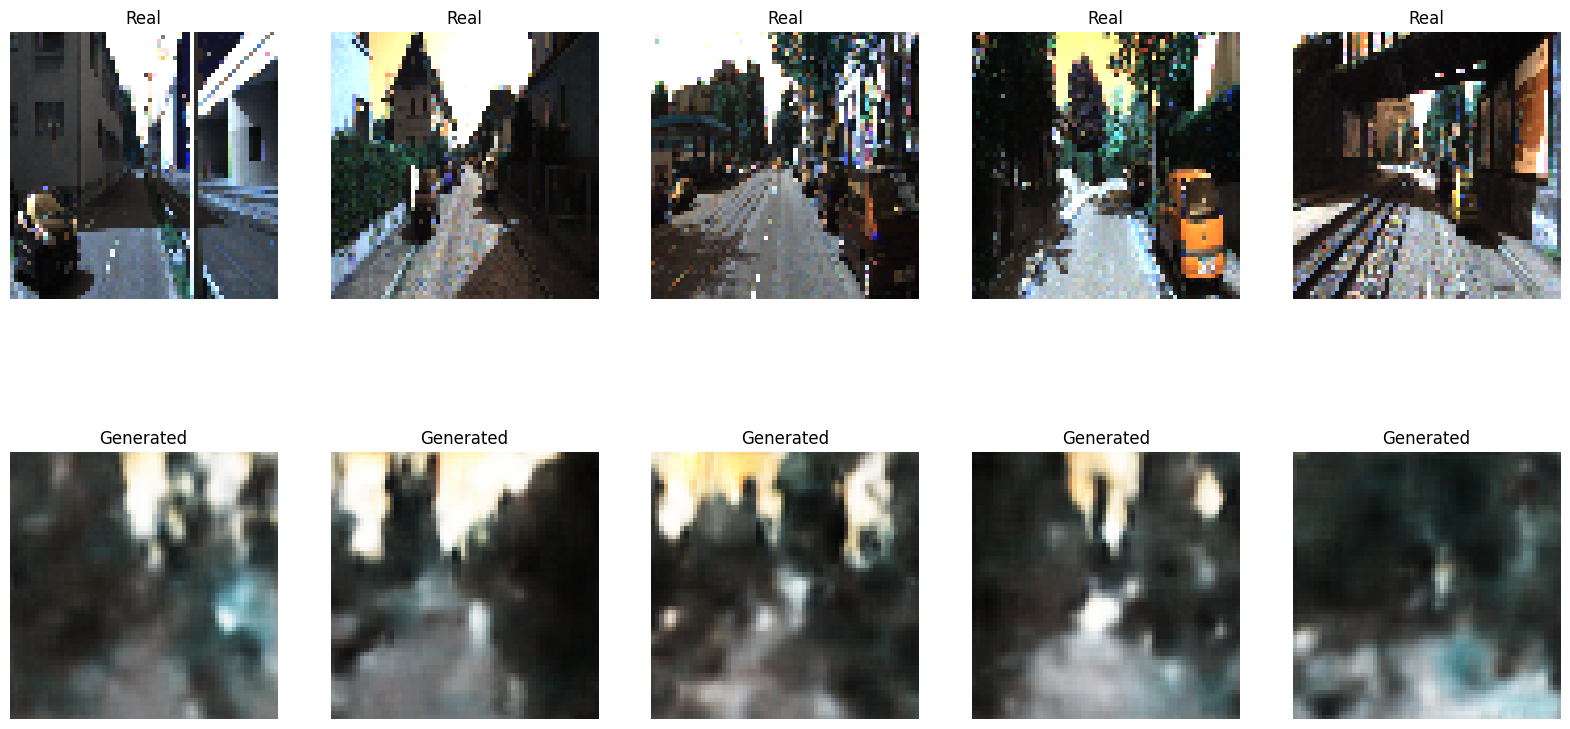

In [8]:
import matplotlib.pyplot as plt

# === Real vs Generated Visualization ===
def visualize_real_and_generated(vae, test_images, num_images=5):
    """
    Visualize real images and their corresponding generated images.
    """
    # Generate reconstructed images
    reconstructed_images = vae.predict(test_images[:num_images])

    # Plot the real images and their reconstructions side by side
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Real Image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title("Real")
        plt.axis("off")

        # Generated Image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Generated")
        plt.axis("off")

    plt.show()

# Visualize Real and Generated Images
print("\nVisualizing Real and Generated Images...")
visualize_real_and_generated(vae, test_images)

In [54]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# Load pre-trained BLIP model and processor (combines vision and text models)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

def generate_image_description(image):
    """
    Generate a description for an image using a pre-trained BLIP model.
    Args:
        image (np.array): The image to generate a description for.
    Returns:
        str: The generated description.
    """
    # Convert numpy array to PIL image
    pil_image = Image.fromarray((image * 255).astype('uint8'))

    # Preprocess the image and generate description
    inputs = processor(pil_image, return_tensors="pt")
    out = model.generate(**inputs)

    # Decode the generated description
    description = processor.decode(out[0], skip_special_tokens=True)
    return description

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


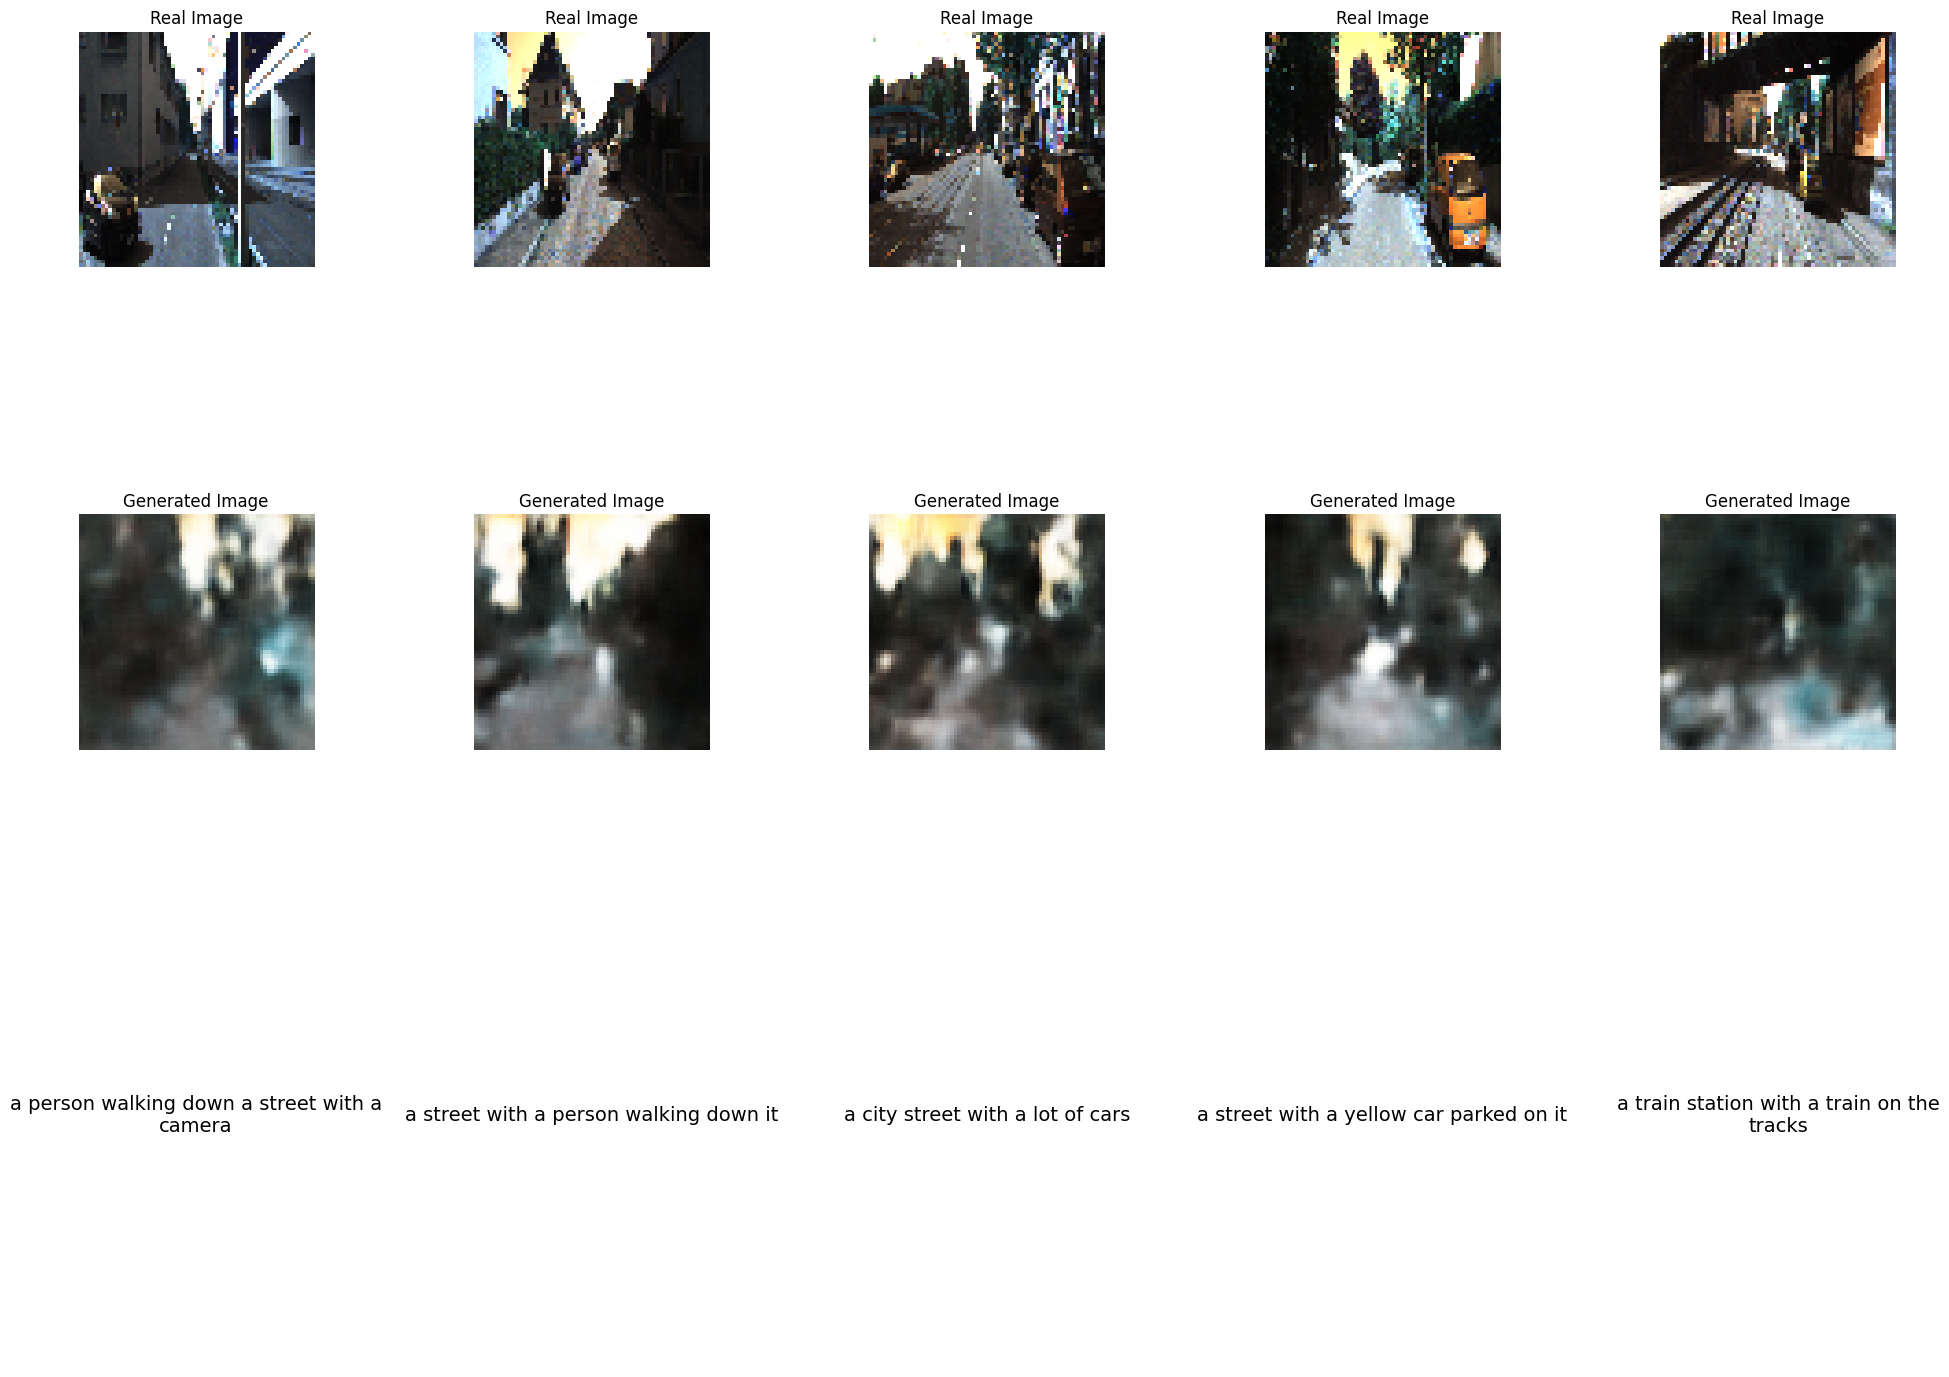

In [56]:
import matplotlib.pyplot as plt

def visualize_real_and_generated_with_bert(vae, test_images, num_images=5):
    """
    Visualize real images, their corresponding generated images, and BERT-generated descriptions.
    """
    # Generate reconstructed images
    reconstructed_images = vae.predict(test_images[:num_images])

    # Plot real images, generated images, and BERT descriptions
    plt.figure(figsize=(20, 15))
    for i in range(num_images):
        # Real Image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title("Real Image")
        plt.axis("off")

        # Generated Image
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Generated Image")
        plt.axis("off")

        # Generate BERT-based description
        description = generate_image_description(test_images[i])

        # Display description
        plt.subplot(3, num_images, i + 1 + (2 * num_images))
        plt.text(0.5, 0.5, description, fontsize=14, ha='center', va='center', wrap=True)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call visualization function
visualize_real_and_generated_with_bert(vae, test_images)

In [58]:
!pip install rouge-score

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=820d8f63a42f08b2856388dcf236c86b84fb5727a4d5e2320cf714d939c06d39
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [59]:
from rouge_score import rouge_scorer

def calculate_rouge(reference, generated):
    """
    Calculate ROUGE score between reference and generated description.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# Example usage
reference_description = "A person is walking in a park."
generated_description = generate_image_description(test_images[0])

rouge_scores = calculate_rouge(reference_description, generated_description)
print(f"ROUGE Scores: {rouge_scores}")

ROUGE Scores: {'rouge1': Score(precision=0.4444444444444444, recall=0.5714285714285714, fmeasure=0.5), 'rouge2': Score(precision=0.125, recall=0.16666666666666666, fmeasure=0.14285714285714288), 'rougeL': Score(precision=0.4444444444444444, recall=0.5714285714285714, fmeasure=0.5)}
